In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import os, time, shap

start = time.time()

In [2]:
# Helper functions
class OneHotEncoder (BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols=None, drop_first=False):
        super().__init__()
        self.drop_first = drop_first
        self.categorical_cols = categorical_cols
        self.categories_ = {}  # Stores categories per column
        self.feature_names_in_ = None

    def get_feature_names_out(self):
        feature_names = []
        if self.feature_names_in_ is None or not self.categories_:
            raise ValueError (f'{OneHotEncoder.__class__.__name__} is not been fitted yet')
        for col in self.feature_names_in_: # append those not transformed first
            if col not in self.categorical_cols:
                feature_names.append(col)
        for col in self.categorical_cols:
            categories = self.categories_[col]
            if len(categories) == 2:
                feature_names.append(f'{col}_{categories[0]}') # take the first
            elif len(categories) > 2:
                if self.drop_first:
                    categories = categories[1:]
                colnames = list(map(lambda cat: f'{col}_{cat}', categories))
                feature_names.extend(colnames)
        return feature_names
    
    def _one_hot_encode(self, values):
        values = np.array(values)
        categories, inverse = np.unique(values, return_inverse=True)
        # drops the last category
        one_hot = np.eye(len(categories))[inverse]
        return one_hot
    
    def fit(self, X, y=None):
        X = X.copy()
        self.feature_names_in_ = X.columns.to_list()

        if self.categorical_cols is None:
            self.categorical_cols = X.select_dtypes(include='object').columns.tolist()
        elif not isinstance(self.categorical_cols, (list, tuple)):
            self.categorical_cols = [self.categorical_cols]

        for col in self.categorical_cols:
            self.categories_[col] = np.sort(np.unique(X[col])).tolist()
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        for col in self.categorical_cols:
            categories = self.categories_[col]
            
            if len(categories) == 2:
                cat = categories[0] # take the first
                col_name = f'{col}_{cat}'
                X_copy[col_name] = (X_copy[col] == cat).astype(int)
            
            elif len(categories) > 2:
                Xcol_one_hot = self._one_hot_encode(X_copy[col]).astype(int)
                if self.drop_first:
                    Xcol_one_hot = Xcol_one_hot[:, 1:]
                    categories = categories[1:]
                for i, cat in enumerate(categories):
                    col_name = f'{col}_{cat}'
                    X_copy[col_name] = Xcol_one_hot[:, i]
        X_copy = X_copy.drop(columns=self.categorical_cols)
        return X_copy
    
class Scaler (BaseEstimator, TransformerMixin):
    def __init__(self, numerical_cols=None, non_numerical_cols=None, fill_missing=False, fill_val=-999):
        super().__init__()
        self.numerical_cols = numerical_cols
        self.non_numerical_cols = non_numerical_cols
        self.fill_missing = fill_missing
        self.fill_val = fill_val
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        if self.numerical_cols is not None and self.non_numerical_cols is not None:
            raise Exception('One of numerical_cols or non_numerical_cols must be provided')
        elif isinstance(self.non_numerical_cols, str) and self.numerical_cols is None: # regex type
            self.non_numerical_cols = X.filter(regex=self.non_numerical_cols).columns.tolist()
            self.numerical_cols = X.drop(columns=self.non_numerical_cols).columns.tolist()
            self.non_numerical_cols = None # set back to None
        elif self.numerical_cols is None:
            self.numerical_cols = X.select_dtypes(np.number).columns.tolist()
        self.scaler.fit(X[self.numerical_cols])
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.numerical_cols] = pd.DataFrame(self.scaler.transform(X_copy[self.numerical_cols]), columns=self.numerical_cols)
        if self.fill_missing:
            X_copy[self.numerical_cols] = X_copy[self.numerical_cols].fillna(self.fill_val)
        return X_copy

## Load Datasets

In [3]:
# load datasets
train = pd.read_parquet('../data/train_agg3.parquet')
test = pd.read_parquet('../data/test_agg3.parquet')

In [4]:
print('Train:', train.shape, ' Test: ', test.shape)

Train: (1000, 208)  Test:  (600, 208)


In [ ]:
print('Missing values')
print('Train:', train.isna().any().sum(), ' Test', test.isna().any().sum())


Missing values
Train: 2  Test 2


## Modelling

In [6]:
# Modelling
drop_cols = ['ID', 'Cropland', 'x', 'y', 'grid_id']
numeric_cols = train.drop(columns=drop_cols).select_dtypes(np.number).columns
cat_cols = ['location', 'region']

seed = 32

In [7]:
# Instantiate models
lgbm = Pipeline([
    ('ohe', OneHotEncoder(cat_cols)),
    ('model', lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.06, random_state=seed, verbose=-1))
    ])
xgbm =  Pipeline([
    ('ohe', OneHotEncoder(cat_cols)),
    ('model', xgb.XGBClassifier(n_estimators=1000, learning_rate=0.06, random_state=seed))
    ])
catm = Pipeline([
    ('ohe', OneHotEncoder(cat_cols)),
    ('model', cat.CatBoostClassifier(n_estimators=1000, learning_rate=0.06, random_state=seed, silent=True))
    ])

In [8]:
# train models
X, y = train.drop(columns=drop_cols), train.Cropland

In [9]:
lgbm.fit(X, y)

Pipeline(steps=[('ohe', OneHotEncoder(categorical_cols=['location', 'region'])),
                ('model',
                 LGBMClassifier(learning_rate=0.06, n_estimators=1000,
                                random_state=32, verbose=-1))])

In [10]:
xgbm.fit(X, y)

Pipeline(steps=[('ohe', OneHotEncoder(categorical_cols=['location', 'region'])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.06,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [11]:
catm.fit(X, y)

Pipeline(steps=[('ohe', OneHotEncoder(categorical_cols=['location', 'region'])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001DD30DD4050>)])

__Test probabilities__

In [12]:
# probabilities
print('Getting test predictions\n==========================')
Xtest = test.drop(columns=drop_cols)
cat_probs = catm.predict_proba(Xtest)
lgb_probs = lgbm.predict_proba(Xtest)
xgb_probs = xgbm.predict_proba(Xtest)

Getting test predictions


In [13]:
# Predictions
cat_preds = cat_probs.argmax(1)
xgb_preds = xgb_probs.argmax(1)
lgb_preds = lgb_probs.argmax(1)
ensemble = np.stack((lgb_probs, xgb_probs, cat_probs)).mean(0).argmax(1)

In [14]:
# save predictions
def save_file(preds, filename):
    folderpath = '../preds/'
    os.makedirs(folderpath, exist_ok=True)
    df = pd.DataFrame({'ID':test.ID, 'Cropland':preds})
    df.to_csv(f'{os.path.join(folderpath, filename)}', index=False)

In [15]:
print('Saving predictions\n=====================')
save_file(ensemble, 'ensemble3.csv')
save_file(cat_preds, 'cat3.csv')
save_file(lgb_preds, 'lgb3.csv')
save_file(xgb_preds, 'xgb3.csv')
print('Files saved!\n')

Saving predictions
Files saved!



## Feature Importance

In [16]:
transformer = OneHotEncoder(cat_cols).fit(X)

In [17]:
def get_shap_vals(model_obj, X):
    X_transformed = transformer.transform(X)
    if hasattr(model_obj, 'named_steps'):
        model_name = list(model_obj.named_steps.keys())[-1]
        model = model_obj.named_steps[model_name]
    else:
        model = model_obj
    explainer = shap.Explainer(model, X_transformed)
    shap_vals = explainer(X_transformed)
    return shap_vals

def plot_shap_values(shap_vals, feature_names, title=None, max_display=None, plot_size=(9,5)):
    if hasattr(shap_vals, 'values'):
        shap.summary_plot(shap_vals, feature_names=feature_names, 
                          plot_type='bar', plot_size=plot_size, 
                          show=False, max_display=max_display)
    else:
        assert len(shap_vals) == len(feature_names), ('Length of shap_values must match with that of feature_names')
        sort_vals = np.argsort(-shap_vals)
        if max_display is None:
            max_display = 20
        shap_vals = shap_vals[sort_vals[:max_display]]
        feature_names = np.array(feature_names)[sort_vals[:max_display]]
        if plot_size is None:
            plot_size = (9,5)
        plt.subplots(1, figsize=plot_size)
        sns.barplot(x=shap_vals, y=feature_names, color='#008bfb', width=0.6, palette=None, linewidth=0)
        sns.despine(top=True, right=True)
    if title is not None:
        plt.title(title, fontsize=12, loc='left', fontweight='bold')
    else:
        plt.title("Feature Importance", fontsize=12, loc='left', fontweight='bold')
    plt.xlabel("Mean |SHAP value|", fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

In [18]:
feature_names = transformer.get_feature_names_out()

cat_shap = get_shap_vals(catm, X)
lgb_shap = get_shap_vals(lgbm, X)
xgb_shap = get_shap_vals(xgbm, X)

 98%|===================| 979/1000 [00:29<00:00]        

In [19]:
# take the absolute mean values of features across all models
combined_shap = np.abs(np.stack([cat_shap.values, lgb_shap.values, xgb_shap.values])).mean(1).mean(0)

In [20]:
# save feature importance
os.makedirs('imgs', exist_ok=True)

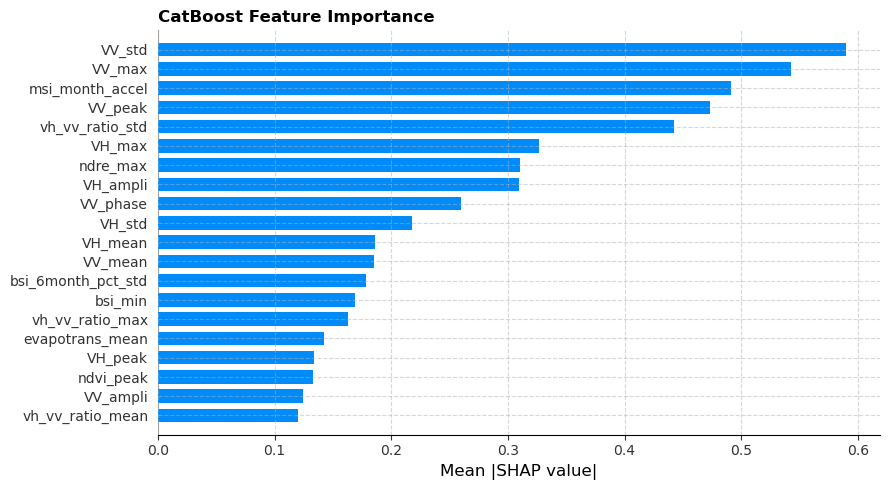

In [21]:
plot_shap_values(cat_shap, feature_names, 'CatBoost Feature Importance')
plt.savefig('imgs/catboost_shap_vals.png')

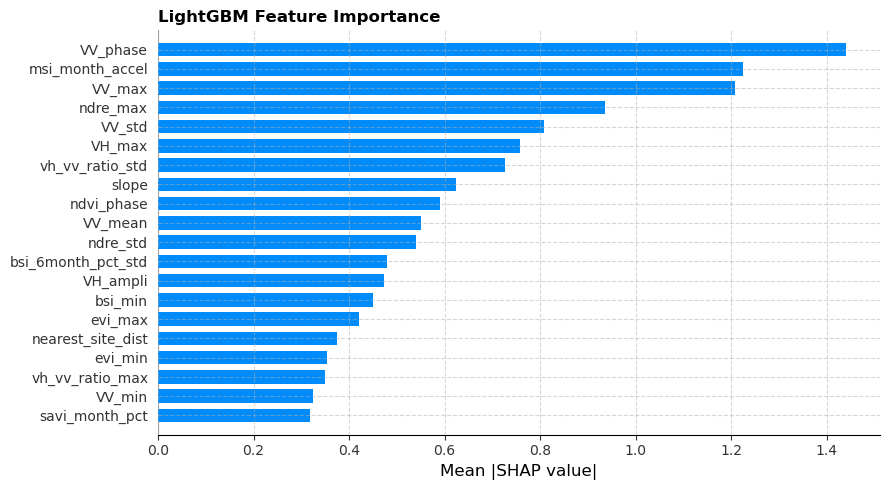

In [22]:
plot_shap_values(lgb_shap, feature_names, 'LightGBM Feature Importance')
plt.savefig('imgs/lightgbm_shap_vals.png')

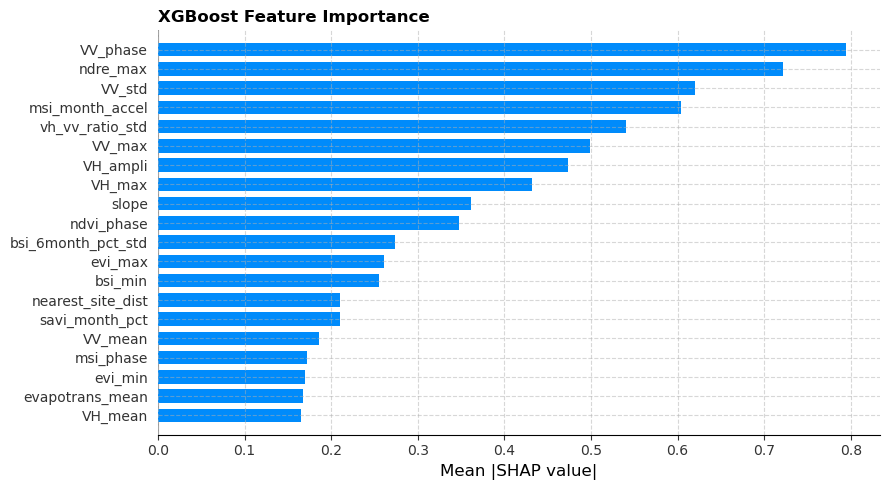

In [23]:
plot_shap_values(xgb_shap, feature_names, 'XGBoost Feature Importance')
plt.savefig('imgs/xgboost_shap_vals.png')

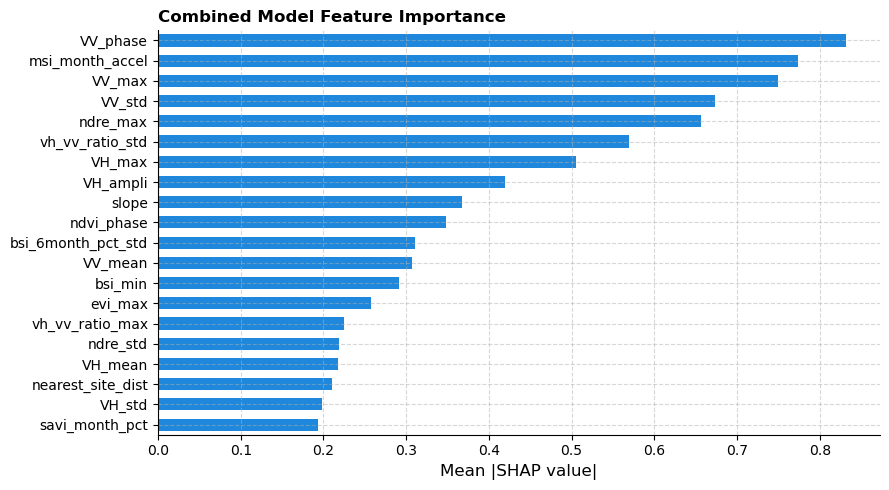

In [24]:
plot_shap_values(combined_shap, feature_names, 'Combined Model Feature Importance')
plt.savefig('imgs/ensemble_shap_vals.png')

In [25]:
end = time.time()

print(f'Total Time taken: {(end-start)/60:.6f} mins')

Total Time taken: 6.433990 mins
